In [ ]:
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt

In [ ]:
!git clone https://github.com/WongKinYiu/yolov9.git

Cloning into 'yolov9'...
remote: Enumerating objects: 668, done.
remote: Counting objects: 100% (290/290), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 668 (delta 222), reused 199 (delta 199), pack-reused 378
Receiving objects: 100% (668/668), 3.22 MiB | 8.40 MiB/s, done.
Resolving deltas: 100% (269/269), done.


In [ ]:
!wget https://s3.us-west-2.amazonaws.com/testing.resources/datasets/deepfashion/deep_fashion.tar

--2024-05-04 15:04:37--  https://s3.us-west-2.amazonaws.com/testing.resources/datasets/deepfashion/deep_fashion.tar
Resolving s3.us-west-2.amazonaws.com (s3.us-west-2.amazonaws.com)... 52.218.153.200, 52.92.234.0, 52.92.209.120, ...
Connecting to s3.us-west-2.amazonaws.com (s3.us-west-2.amazonaws.com)|52.218.153.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17681387520 (16G) [application/x-tar]
Saving to: ‘deep_fashion.tar’

deep_fashion.tar    100%[===================>]  16.47G  39.8MB/s    in 7m 57s  

2024-05-04 15:12:34 (35.4 MB/s) - ‘deep_fashion.tar’ saved [17681387520/17681387520]



In [38]:
import tarfile
import os
import cv2
import matplotlib.pyplot as plt
import json
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil
import argparse
import yaml
from PIL import Image, ImageDraw
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import torch
import torchvision.transforms as transforms
import numpy as np
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

In [ ]:
tar_path = "/content/deep_fashion.tar"
with tarfile.open(tar_path, 'r') as tar:
    tar.extractall()

In [ ]:
os.chdir("/content/deep_fashion/images/train")
files = os.listdir()
num_files = len(files)
file_types = set()
for file in files:
    if os.path.isfile(file):
        file_extension = os.path.splitext(file)[1]
        file_types.add(file_extension)
print("Number of files:", num_files)
print("File types present:", file_types)

Number of files: 191961
File types present: {'.jpg'}


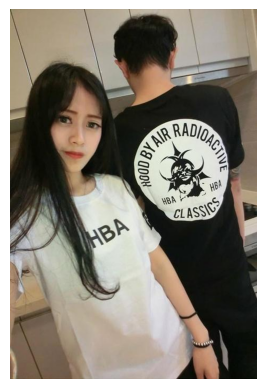

In [ ]:
def show_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.show()
image_path = "/content/deep_fashion/images/train/000002.jpg"
show_image(image_path)

In [ ]:
json_file_path = "/content/deep_fashion/annotations/instances_train2024.json"
with open(json_file_path, "r") as f:
    first_few_chars = f.read(8000)
print(first_few_chars)

{
    "info": {
        "year": "2024",
        "version": "1",
        "description": "Sample dataset created from MSCOCO",
        "contributors": "Matrice.ai",
        "url": "",
        "date_created": "2024-03-13 08:06:01"
    },
    "categories": [
        {
            "id": 8,
            "name": "trousers",
            "supercategory": "deep fashion"
        },
        {
            "id": 1,
            "name": "short sleeve top",
            "supercategory": "deep fashion"
        },
        {
            "id": 11,
            "name": "long sleeve dress",
            "supercategory": "deep fashion"
        },
        {
            "id": 2,
            "name": "long sleeve top",
            "supercategory": "deep fashion"
        },
        {
            "id": 9,
            "name": "skirt",
            "supercategory": "deep fashion"
        },
        {
            "id": 7,
            "name": "shorts",
            "supercategory": "deep fashion"
        },
        {
       

In [ ]:
with open(json_file_path, "r") as f:
    data_category = json.load(f)
categories = data_category.pop("categories")
df = pd.DataFrame(data_category.pop("annotations"))
df_category = pd.DataFrame(categories)
print(df.head())

                                        segmentation  \
0  [[460, 438, 374, 484, 251, 520, 269, 586, 298,...   
1  [[257, 35, 261, 89, 228, 123, 137, 103, 45, 91...   
2  [[220.25, 187.55, 259.6, 177.6, 296.6, 158.6, ...   
3  [[145.21, 314.0, 162.67, 312.8, 175.12, 313.05...   
4  [[338, 64, 299, 133, 228, 189, 183, 121, 160, ...   

                                           landmarks  category_id is_crowd  \
0  [251, 520, 1, 374, 484, 1, 460, 438, 1, 269, 5...            8      [0]   
1  [182, 54, 1, 45, 91, 1, 137, 103, 1, 228, 123,...            1      [0]   
2  [271, 172, 2, 313, 145, 2, 0, 0, 0, 0, 0, 0, 0...            1      [0]   
3  [127, 335, 1, 73, 340, 1, 107, 354, 1, 140, 35...            1      [0]   
4  [240, 108, 2, 160, 63, 2, 183, 121, 2, 228, 18...           11      [0]   

                   bbox  id image_id  
0  [249, 423, 217, 200]   1   000001  
1     [0, 29, 466, 593]   2   000001  
2  [165, 133, 301, 439]   3   000002  
3    [1, 300, 366, 401]   4   000002  

In [ ]:
image_category_counts = df.groupby('image_id')['category_id'].nunique()
equal_quantity_images = image_category_counts[image_category_counts == image_category_counts.iloc[0]].index
equal_quantity_images_df = pd.DataFrame(equal_quantity_images, columns=['image_id'])
equal_quantity_images_df = equal_quantity_images_df.sample(frac=1).reset_index(drop=True)
selected_images = equal_quantity_images_df['image_id'][:500]
filtered_df = df[df['image_id'].isin(selected_images)]
print(filtered_df.head())

                                           segmentation  \
1052  [[273, 560, 345, 570, 415, 565, 435, 660, 454,...   
1053  [[315, 468, 319, 425, 325, 381, 281, 390, 249,...   
1511  [[288, 435, 217, 445, 152, 438, 147, 533, 156,...   
1512  [[206, 191, 206, 165, 204, 140, 188, 145, 168,...   
1691  [[452, 297, 426, 299, 396, 318, 391, 289, 371,...   

                                              landmarks  category_id is_crowd  \
1052  [273, 560, 1, 345, 570, 1, 415, 565, 1, 249, 6...            9      [0]   
1053  [366, 384, 1, 325, 381, 2, 319, 425, 2, 315, 4...            4      [0]   
1511  [152, 438, 1, 217, 445, 1, 288, 435, 1, 147, 5...            8      [0]   
1512  [234, 157, 1, 204, 140, 1, 206, 165, 2, 206, 1...            4      [0]   
1691  [400, 283, 1, 371, 268, 1, 391, 289, 1, 396, 3...            2      [0]   

                      bbox    id image_id  
1052  [201, 543, 268, 254]  1053   000643  
1053  [224, 370, 253, 326]  1054   000643  
1511  [138, 423, 159, 319]

In [ ]:
print(len(filtered_df))
print(len(filtered_df['image_id'].unique()))

1004
500


In [ ]:
category_counts = df['category_id'].value_counts()
print(category_counts)

category_id
1     71645
8     55387
7     36616
2     36064
9     30835
12    17949
10    17211
5     16095
4     13457
11     7907
13     6492
6      1985
3       543
Name: count, dtype: int64


In [ ]:
filtered_image_ids = filtered_df['image_id'].unique()
folder_path = "/content/deep_fashion/images/train"
all_files = os.listdir(folder_path)
for file_name in all_files:
    image_id = file_name.split(".")[0]
    if image_id not in filtered_image_ids:
        file_path = os.path.join(folder_path, file_name)
        os.remove(file_path)

In [ ]:
df_shuffled = filtered_df.sample(frac=1, random_state=42)
train_size = int(0.7 * len(df_shuffled))
val_size = int(0.2 * len(df_shuffled))
test_size = len(df_shuffled) - train_size - val_size
train_df, temp_df = train_test_split(df_shuffled, train_size=train_size, random_state=42)
val_df, test_df = train_test_split(temp_df, train_size=val_size, random_state=42)
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
print("Train set size:", len(train_df))
print("Validation set size:", len(val_df))
print("Test set size:", len(test_df))


Train set size: 702
Validation set size: 200
Test set size: 102


In [ ]:
import json
import numpy as np

def dataframe_to_coco(dataframe, image_dir, output_json):
  coco_data = {}
  coco_data["info"] = {}
  coco_data["licenses"] = []
  coco_data["images"] = []
  coco_data["annotations"] = []
  coco_img_id = 0
  coco_ann_id = 0

  categories = [
      {
            "id": 8,
            "name": "trousers"
        },
        {
            "id": 1,
            "name": "short sleeve top"
        },
        {
            "id": 11,
            "name": "long sleeve dress"
        },
        {
            "id": 2,
            "name": "long sleeve top"
        },
        {
            "id": 9,
            "name": "skirt"
        },
        {
            "id": 7,
            "name": "shorts"
        },
        {
            "id": 4,
            "name": "long sleeve outwear"
        },
        {
            "id": 12,
            "name": "vest dress"
        },
        {
            "id": 10,
            "name": "short sleeve dress"
        },
        {
            "id": 5,
            "name": "vest"
        },
        {
            "id": 13,
            "name": "sling dress"
        },
        {
            "id": 3,
            "name": "short sleeve outwear"
        },
        {
            "id": 6,
            "name": "sling"
        }
  ]
  coco_data["categories"] = categories

  for index, row in dataframe.iterrows():
    image_id = coco_img_id
    coco_img_id += 1

    image_file = os.path.join(image_dir, row["image_id"])
    image_width, image_height = (640, 960)

    image = {
        "id": image_id,
        "file_name": image_file,
        "width": image_width,
        "height": image_height,
    }
    coco_data["images"].append(image)

    segmentation = row["segmentation"]
    rle = []
    for contour in segmentation:
      contour = np.array(contour).reshape((-1, 1, 2))
      rle.extend(cv2.imencode(".png", contour)[1].flatten())

    area = cv2.contourArea(np.array(segmentation))

    annotation = {
        "id": coco_ann_id,
        "image_id": image_id,
        "category_id": row["category_id"],
        "iscrowd": row["is_crowd"],
        "area": area,
        "segmentation": rle,
        "bbox": row["bbox"],
        "landmarks": row["landmarks"],
    }
    coco_data["annotations"].append(annotation)
    coco_ann_id += 1

  with open("coco_fomat.yaml", "w") as f:
    yaml.dump(coco_data, f)

dataframe = train_df
image_dir = "/content/deep_fashion/images/train"
output_json = "train_coco.json"

dataframe_to_coco(dataframe, image_dir, output_json)

In [25]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 7])
        image = Image.open(img_name)

        segmentation = self.dataframe.iloc[idx, 0]
        landmarks = self.dataframe.iloc[idx, 1]
        category_id = self.dataframe.iloc[idx, 2]
        is_crowd = self.dataframe.iloc[idx, 3]
        bbox = self.dataframe.iloc[idx, 4]

        sample = {
            'image': image,
            'segmentation': segmentation,
            'landmarks': landmarks,
            'category_id': category_id,
            'is_crowd': is_crowd,
            'bbox': bbox
        }

        if self.transform:
            sample = self.transform(sample)

        return sample

In [26]:
root_dir = '/content/deep_fashion/images/train'
transform = ToTensor()
dataset = CustomDataset(dataframe=train_df, root_dir=root_dir, transform=transform)

In [ ]:
sample = dataset[0]

# You can now access elements of the sample dictionary
print(image = sample['image'])  # Image tensor
print(segmentation = sample['segmentation'])  # Segmentation mask
print(landmarks = sample['landmarks'])  # Landmarks
print(category_id = sample['category_id'])  # Category ID
print(is_crowd = sample['is_crowd'])  # Crowd information
print(bbox = sample['bbox'])  # Bounding box coordinates

In [27]:
modified_yaml_file_path = '/content/yolov9-c.yaml'
yolov9_repo_dir = '/content/yolov9'
destination_dir = f'{yolov9_repo_dir}/models/detect/'
shutil.copy(modified_yaml_file_path, destination_dir)

'/content/yolov9/models/detect/yolov9-c.yaml'

In [28]:
def parse_opt(config_file=None, known=False):
    parser = argparse.ArgumentParser()
    parser.add_argument('--config', type=str, default=config_file, help='Config YAML file path')
    args, _ = parser.parse_known_args()

    if args.config is None:
        parser.error('Please provide the path to the config YAML file using --config')

    with open(args.config, 'r') as f:
        config = yaml.safe_load(f)

    parser = argparse.ArgumentParser()
    for key, value in config.items():
        if isinstance(value, bool):
            parser.add_argument(f'--{key}', action='store_true', help=f'{key}')
        else:
            parser.add_argument(f'--{key}', type=type(value), default=value, help=f'{key}')

    return parser.parse_known_args()[0] if known else parser.parse_args()

In [ ]:
!python train.py --config /content/config.yaml


In [ ]:
model = torch.load("/content/model.pt")
transform = transforms.Compose([
    transforms.ToTensor(),
])
image_path = "/content/deep_fashion/images/train/052609.jpg"
image = Image.open(image_path).convert("RGB")

input_image = transform(image)
input_image = input_image.unsqueeze(0)

with torch.no_grad():
    output = model(input_image)

bounding_boxes = output["bounding_boxes"]
masks = output["masks"]

bounding_boxes = bounding_boxes.detach().cpu().numpy()
masks = masks.detach().cpu().numpy()

plt.figure(figsize=(10, 10))
plt.imshow(image)

for box in bounding_boxes:
    x, y, w, h = box
    plt.gca().add_patch(plt.Rectangle((x, y), w, h, fill=False, edgecolor="red", linewidth=2))

for mask in masks:
    plt.imshow(mask, alpha=0.5)

plt.axis("off")
plt.show()

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

val_coco = COCO("/content/val.json")
test_coco = COCO("/content/test.json")

val_detection_results = []
test_detection_results = []

for img_id in val_coco.getImgIds():
    img_info = val_coco.loadImgs(img_id)[0]
    image_path = "content/val/" + img_info["images"]
    image = Image.open(image_path).convert("RGB")

    input_image = transform(image)
    input_image = input_image.unsqueeze(0)

    with torch.no_grad():
        output = model(input_image)

    detection_results = process_detection_results(output, img_info["id"])
    val_detection_results.extend(detection_results)

for img_id in test_coco.getImgIds():
    img_info = test_coco.loadImgs(img_id)[0]
    image_path = "/content/test/" + img_info["images_test"]
    image = Image.open(image_path).convert("RGB")

    input_image = transform(image)
    input_image = input_image.unsqueeze(0)

    with torch.no_grad():
        output = model(input_image)

    detection_results = process_detection_results(output, img_info["id"])
    test_detection_results.extend(detection_results)

val_detections = val_coco.loadRes(val_detection_results)
val_eval = COCOeval(val_coco, val_detections, iouType="bbox")
val_eval.evaluate()
val_eval.accumulate()
val_eval.summarize()
print("Validation detection metrics:")
print(val_eval.stats)

test_detections = test_coco.loadRes(test_detection_results)
test_eval = COCOeval(test_coco, test_detections, iouType="bbox")
test_eval.evaluate()
test_eval.accumulate()
test_eval.summarize()
print("Test detection metrics:")
print(test_eval.stats)